## Word Vectors :

**Word2vec** is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
%matplotlib inline

In [0]:
df = pd.read_csv('/content/drive/My Drive/bbc-text.csv')

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [0]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [7]:
df_clean.head()

,text
0,tv future hands viewers home theatre systems p...
1,worldcom boss left books alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...
3,yeading face newcastle fa cup premiership side...
4,ocean twelve raids box office ocean twelve cri...


In [0]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)

In [9]:
df_clean.head()

,text,text_lemmatize
0,tv future hands viewers home theatre systems p...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldcom...,worldcom boss leave book alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...,tigers wary farrell gamble leicester say rush ...
3,yeading face newcastle fa cup premiership side...,yeade face newcastle fa cup premiership side n...
4,ocean twelve raids box office ocean twelve cri...,ocean twelve raid box office ocean twelve crim...


In [0]:
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [11]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

25892

In [12]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'mr', 'year', 'would', 'make', 'also', 'people', 'new', 'one', 'take']

`Word2Vec is a shallow, two-layer neural networks which is trained to reconstruct linguistic contexts of words.
It takes as its input a large corpus of words and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.
Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.`

Word2Vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text.
It comes in two flavors, the Continuous Bag-of-Words (CBOW) model and the Skip-Gram model.

Algorithmically, these models are similar.

In [0]:
# min_count: minimum number of occurrences of a word in the corpus to be included in the model.
# window: the maximum distance between the current and predicted word within a sentence.
# size: the dimensionality of the feature vectors
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100)

The architecture is similar to **an autoencoder’s** one, you take a large input vector, compress it down to a smaller dense vector and then instead of decompressing it back to the original input vector as you do with autoencoders, you output probabilities of target words.


<img src='https://israelg99.github.io/images/2017-03-23-Word2Vec-Explained/skip_gram_net_arch.png'>

<img src='https://israelg99.github.io/images/2017-03-23-Word2Vec-Explained/output_weights_function.png'>

In [0]:
# this line of code to prepare the model vocabulary
w2v_model.build_vocab(sentences)

In [15]:
# train word vectors
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(966433, 2384980)

In [0]:
# As we do not plan to train the model any further, 
# we are calling init_sims(), which will make the model much more memory-efficient
w2v_model.init_sims(replace=True)

In [17]:
# Explore the model
w2v_model.wv.most_similar(positive=['economy'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('economic', 0.9803987741470337),
 ('rate', 0.9455578327178955),
 ('growth', 0.9372615814208984),
 ('continue', 0.9334832429885864),
 ('interest', 0.9174902439117432),
 ('low', 0.8795485496520996),
 ('spending', 0.8721782565116882),
 ('demand', 0.8599507808685303),
 ('however', 0.8531502485275269),
 ('job', 0.8502475619316101)]

<img src='https://israelg99.github.io/images/2017-03-23-Word2Vec-Explained/word2vec_weight_matrix_lookup_table.png'>

In [18]:
w2v_model.wv.most_similar(positive=['president'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('commission', 0.95391845703125),
 ('foreign', 0.9307883977890015),
 ('state', 0.8970992565155029),
 ('financial', 0.8934593200683594),
 ('investment', 0.8665763735771179),
 ('agree', 0.864859402179718),
 ('house', 0.8607426881790161),
 ('fund', 0.8597755432128906),
 ('trade', 0.8575888872146606),
 ('raise', 0.8435956239700317)]

In [19]:
# how similar are these two words to each other 
w2v_model.wv.similarity('company', 'business')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.8821525

In [0]:
import matplotlib.pyplot as plt

def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

<img src='https://israelg99.github.io/images/2017-03-23-Word2Vec-Explained/linear-relationships.png'>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


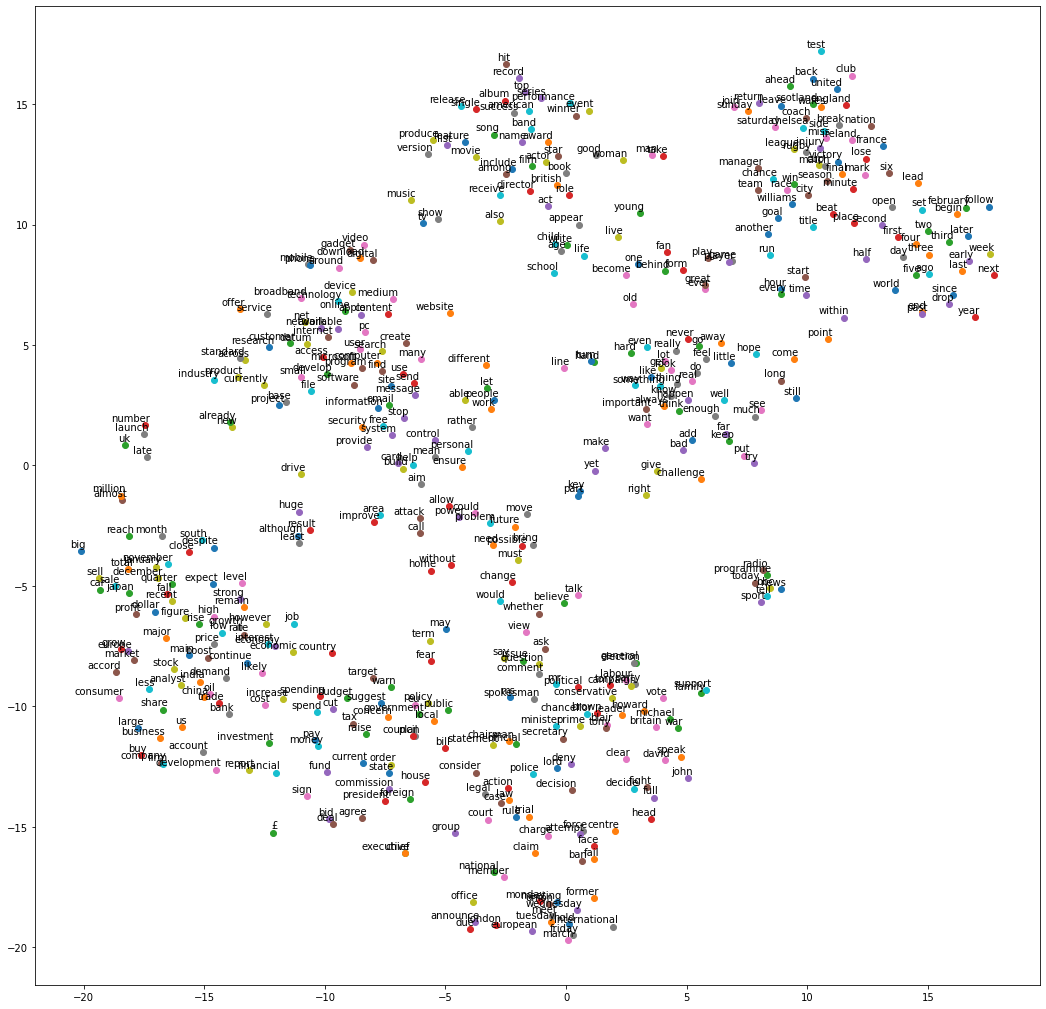

In [21]:
# Use t-SNE to represent high-dimensional data 
# and the underlying relationships between vectors in a lower-dimensional space.
tsne_plot(w2v_model)

In [0]:
# from gensim.models import KeyedVectors

# filename = 'GoogleNews-vectors-negative300.bin.gz'
# model = KeyedVectors.load_word2vec_format(filename, binary=True)
# calculate: (king - man) + woman = ?
# result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
# print(result)